Notebook para la pruebas de clasificación de Click_Bait usando otros modelos BERT.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset, Dataset
from transformers import (
    Trainer,
    TrainingArguments
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

/home/hyperm/proyectos/clickbait_roberta/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ.pop("TRANSFORMERS_OFFLINE", None)
os.environ.pop("HF_HUB_OFFLINE", None)

Se hacen configuraciones basicas para una primera prueba, y se muestra si el entorno es capaz de ejecutarse en CUDA o con el CPU

In [3]:
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
NUM_LABELS = 2          # 0 = no clickbait, 1 = clickbait
MAX_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 15

ejemplo = "sanidad revende 30.000 dosis de la vacuna contra el coronavirus a Andorra"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


Carga de los csv ya Pre divididos, 75 - 25, y codificación del target

In [4]:
data_files = {
    "train": "TA1C_dataset_detection_train_split.csv",
    "test": "TA1C_dataset_detection_dev_split.csv",
}

dataset = load_dataset("csv", data_files=data_files)
dataset = dataset.class_encode_column("Tag Value")
dataset = dataset.rename_column("Tag Value", "labels")

print("Ejemplo de fila:", dataset["train"][1])

Ejemplo de fila: {'Teaser Text': 'sanidad revende 30.000 dosis de la vacuna contra el coronavirus a andorra', 'labels': 1}


Se realiza la selección del modelo y tokenización de los features

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

print(tokenizer.__class__.__name__)
print(model.__class__.__name__)

def tokenize_function(examples):
    return tokenizer(
        examples["Teaser Text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

encoded_dataset = dataset.map(tokenize_function, batched=True)

encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

train_dataset = encoded_dataset["train"]
eval_dataset  = encoded_dataset["test"]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTokenizerFast
BertForSequenceClassification


Ejemplo de tokenización

In [6]:
tokens = tokenizer.tokenize(ejemplo)
print("Tokens:\n", tokens)

encoding = tokenizer(
    ejemplo,
    truncation=True,
    padding="max_length",
    max_length=128,
)

print("\n", encoding.keys())
print("\n", encoding["input_ids"][:20])
print("\n", encoding["attention_mask"][:20])

decodificado = tokenizer.decode(encoding["input_ids"], skip_special_tokens=True)
print("\nMensaje decodificado:\n", decodificado)

Tokens:
 ['sanidad', 'rev', '##ende', '30', '.', '000', 'dosis', 'de', 'la', 'vacuna', 'contra', 'el', 'corona', '##vir', '##us', 'a', 'Andorra']

 KeysView({'input_ids': [4, 17986, 4511, 23281, 2101, 1009, 2273, 6781, 1008, 1030, 19175, 1534, 1040, 12078, 2388, 1212, 1013, 23911, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Definición de metricas

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc         = accuracy_score(labels, preds)
    f1_macro    = f1_score(labels, preds, average="macro")
    f1_weighted = f1_score(labels, preds, average="weighted")
    prec_macro  = precision_score(labels, preds, average="macro", zero_division=0)
    rec_macro   = recall_score(labels, preds, average="macro", zero_division=0)

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
    }

Argumentos de entrenamiento

In [8]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=0,
    data_seed=0,
    logging_steps=50,
    logging_dir="./logs",
    report_to="none",
)

Definición del entrenador

In [9]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

Ejecución

In [10]:
print("Entrenando modelo BERT en español para clickbait")
trainer.train()
print("\nEvaluando en test")
metrics_BETO = trainer.evaluate()
print("\nMétricas de evaluación:", metrics_BETO)

Entrenando modelo BERT en español para clickbait


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.341200,0.416305,0.862857,0.831493,0.862649,0.832508,0.830500
2,0.222800,0.459047,0.872857,0.844483,0.872952,0.843972,0.845000
3,0.029500,0.735718,0.880000,0.850724,0.879056,0.856553,0.845500
4,0.049000,0.790587,0.884286,0.850440,0.880932,0.874673,0.833500
5,0.002700,0.936660,0.878571,0.841367,0.874291,0.871058,0.822000
6,0.000100,1.026682,0.871429,0.836921,0.869071,0.850855,0.826000
7,0.013400,0.971870,0.895714,0.861216,0.890871,0.904709,0.835500
8,0.000000,0.981212,0.891429,0.858419,0.887717,0.888384,0.838500
9,0.000000,1.047544,0.887143,0.857091,0.885177,0.871010,0.846000
10,0.027900,1.055856,0.870000,0.841460,0.870288,0.839971,0.843000



Evaluando en test



Métricas de evaluación: {'eval_loss': 0.971869707107544, 'eval_accuracy': 0.8957142857142857, 'eval_f1_macro': 0.8612163531133978, 'eval_f1_weighted': 0.8908707364379432, 'eval_precision_macro': 0.9047093451066961, 'eval_recall_macro': 0.8354999999999999, 'eval_runtime': 1.2694, 'eval_samples_per_second': 551.461, 'eval_steps_per_second': 69.326, 'epoch': 15.0}


Predicciones, Matriz y Reporte

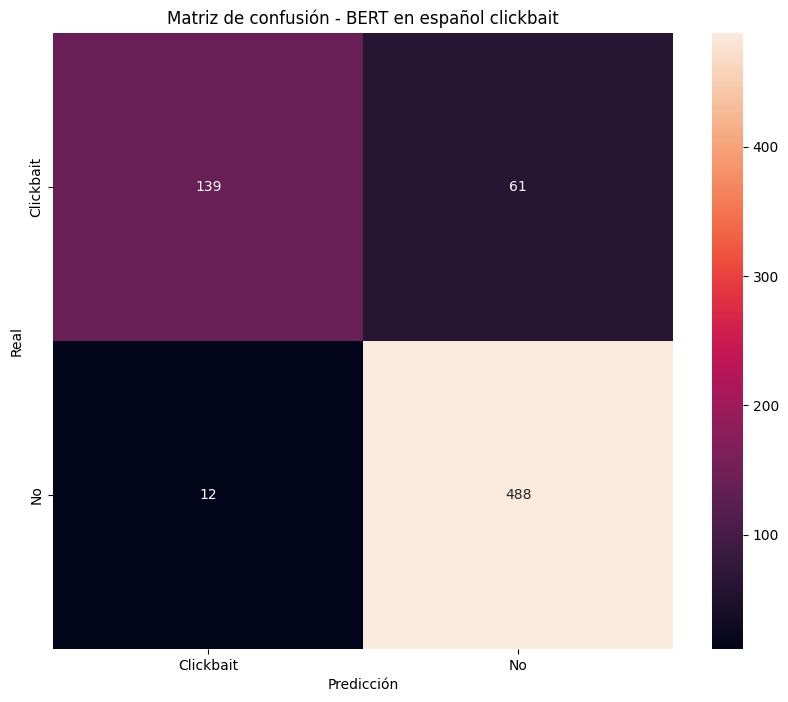


Reporte de clasificación BERT en español:
              precision    recall  f1-score   support

   Clickbait       0.92      0.69      0.79       200
          No       0.89      0.98      0.93       500

    accuracy                           0.90       700
   macro avg       0.90      0.84      0.86       700
weighted avg       0.90      0.90      0.89       700



In [11]:
predictions = trainer.predict(eval_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,        # muestra los números
    fmt="d",           # enteros
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - BERT en español clickbait")
plt.show()

print("\nReporte de clasificación BERT en español:")
class_BETO = classification_report(y_true, y_pred, target_names=label_names)
print(class_BETO)

# Otros Modelos

## DistilBETO

Tokenización

In [12]:
MODEL_NAME = "dccuchile/distilbert-base-spanish-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

encoded_dataset = dataset.map(tokenize_function, batched=True)

encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

train_dataset = encoded_dataset["train"]
eval_dataset  = encoded_dataset["test"]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/distilbert-base-spanish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ejemplo de tokenización

In [13]:
tokens = tokenizer.tokenize(ejemplo)
print("Tokens:\n", tokens)

encoding = tokenizer(
    ejemplo,
    truncation=True,
    padding="max_length",
    max_length=128,
)

print("\n", encoding.keys())
print("\n", encoding["input_ids"][:20])
print("\n", encoding["attention_mask"][:20])

decodificado = tokenizer.decode(encoding["input_ids"], skip_special_tokens=True)
print("\nMensaje decodificado:\n", decodificado)

Tokens:
 ['sanidad', 'reven', '##de', '30', '.', '000', 'dosis', 'de', 'la', 'vacuna', 'contra', 'el', 'corona', '##vir', '##us', 'a', 'andorra']

 KeysView({'input_ids': [4, 14609, 28986, 1114, 2286, 1008, 2371, 9934, 1009, 1032, 18742, 1532, 1039, 8132, 10791, 1108, 1012, 22742, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Nuevo modelo

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

Entrenamiento

In [15]:
print("Entrenando modelo DistilBETO para clickbait")
trainer.train()
print("\nEvaluando en test")
metrics_destil = trainer.evaluate()
print("\nMétricas de evaluación:", metrics_destil)

Entrenando modelo DistilBETO para clickbait


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.381800,0.408158,0.838571,0.792082,0.834217,0.810902,0.779000
2,0.226400,0.490105,0.852857,0.821601,0.853604,0.818468,0.825000
3,0.125100,0.738460,0.838571,0.806495,0.840260,0.800647,0.813500
4,0.060300,0.818202,0.857143,0.816321,0.853432,0.835738,0.802500
5,0.022100,0.913272,0.852857,0.817815,0.852058,0.821407,0.814500
6,0.017300,0.964624,0.855714,0.823514,0.855822,0.823034,0.824000
7,0.016500,0.955849,0.855714,0.821352,0.854931,0.824984,0.818000
8,0.000400,1.041373,0.854286,0.822032,0.854502,0.821086,0.823000
9,0.018900,1.052867,0.861429,0.828956,0.860896,0.831556,0.826500
10,0.007400,1.171217,0.844286,0.812290,0.845504,0.807718,0.817500



Evaluando en test



Métricas de evaluación: {'eval_loss': 1.0528672933578491, 'eval_accuracy': 0.8614285714285714, 'eval_f1_macro': 0.8289564834057561, 'eval_f1_weighted': 0.860896242116722, 'eval_precision_macro': 0.8315562325463315, 'eval_recall_macro': 0.8265, 'eval_runtime': 0.7417, 'eval_samples_per_second': 943.788, 'eval_steps_per_second': 118.648, 'epoch': 15.0}


Metricas de rendimiento

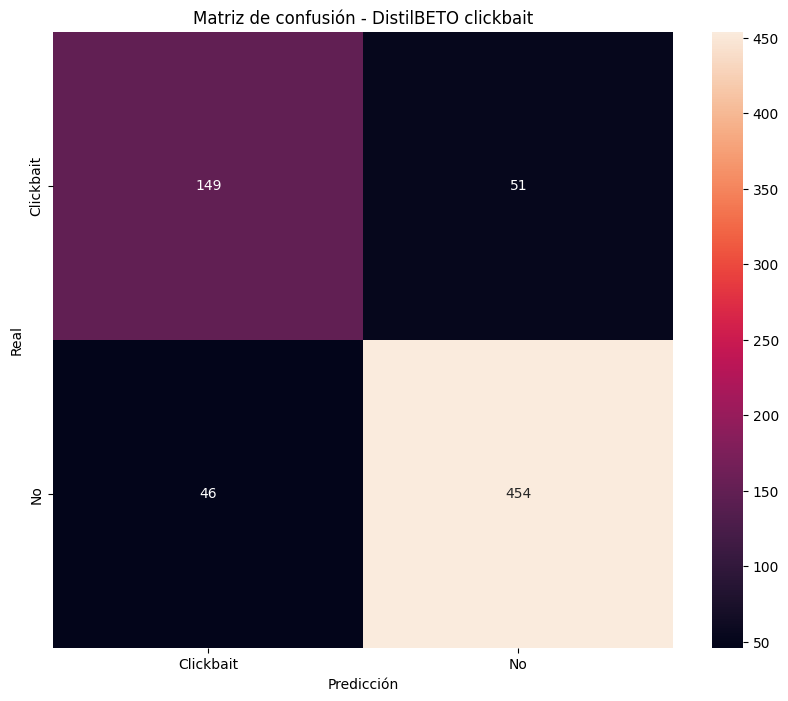


Reporte de clasificación DestilBETO en español:
              precision    recall  f1-score   support

   Clickbait       0.76      0.74      0.75       200
          No       0.90      0.91      0.90       500

    accuracy                           0.86       700
   macro avg       0.83      0.83      0.83       700
weighted avg       0.86      0.86      0.86       700



In [16]:
predictions = trainer.predict(eval_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - DistilBETO clickbait")
plt.show()

print("\nReporte de clasificación DestilBETO en español:")
class_destilBETO = classification_report(y_true, y_pred, target_names=label_names)
print(class_destilBETO)

## RoBERTa Español

Tokenización

In [17]:
MODEL_NAME = "bertin-project/bertin-roberta-base-spanish"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

encoded_dataset = dataset.map(tokenize_function, batched=True)

encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

train_dataset = encoded_dataset["train"]
eval_dataset  = encoded_dataset["test"]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bertin-project/bertin-roberta-base-spanish and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ejemplo de tokenización

In [18]:
tokens = tokenizer.tokenize(ejemplo)
print("Tokens:\n", tokens)

encoding = tokenizer(
    ejemplo,
    truncation=True,
    padding="max_length",
    max_length=128,
)

print("\n", encoding.keys())
print("\n", encoding["input_ids"][:20])
print("\n", encoding["attention_mask"][:20])

decodificado = tokenizer.decode(encoding["input_ids"], skip_special_tokens=True)
print("\nMensaje decodificado:\n", decodificado)

Tokens:
 ['san', 'idad', 'Ġrev', 'ende', 'Ġ30', '.', '000', 'Ġdosis', 'Ġde', 'Ġla', 'Ġvacuna', 'Ġcontra', 'Ġel', 'Ġcoronavirus', 'Ġa', 'ĠAndorra']

 KeysView({'input_ids': [0, 4181, 425, 1595, 2517, 2001, 68, 1160, 11398, 313, 332, 21028, 809, 344, 40954, 320, 18211, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Trainer con el modelo actual

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

Entrenamiento

In [20]:
print("Entrenando modelo RoBERTa en español para clickbait")
trainer.train()
print("\nEvaluando en test")
metrics_RoBERTa = trainer.evaluate()
print("\nMétricas de evaluación:", metrics_RoBERTa)

Entrenando modelo RoBERTa en español para clickbait


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.414500,0.447745,0.861429,0.821522,0.857691,0.842103,0.807000
2,0.243400,0.543081,0.865714,0.830794,0.863738,0.841550,0.822000
3,0.142600,0.554650,0.875714,0.837634,0.871333,0.867024,0.818500
4,0.038300,0.799448,0.875714,0.837043,0.871065,0.868523,0.817000
5,0.078700,0.783551,0.877143,0.845698,0.875551,0.855473,0.837500
6,0.015000,0.859099,0.865714,0.827936,0.862489,0.846305,0.814500
7,0.000400,0.996109,0.860000,0.830993,0.861000,0.826531,0.836000
8,0.011600,1.055190,0.867143,0.837493,0.867242,0.836992,0.838000
9,0.000100,1.016665,0.867143,0.833408,0.865536,0.842167,0.826000
10,0.000100,1.102293,0.865714,0.833991,0.865092,0.837191,0.831000



Evaluando en test



Métricas de evaluación: {'eval_loss': 0.7835509181022644, 'eval_accuracy': 0.8771428571428571, 'eval_f1_macro': 0.845697998687664, 'eval_f1_weighted': 0.8755507124109486, 'eval_precision_macro': 0.8554726996966633, 'eval_recall_macro': 0.8375, 'eval_runtime': 1.2405, 'eval_samples_per_second': 564.303, 'eval_steps_per_second': 70.941, 'epoch': 15.0}


Metricas

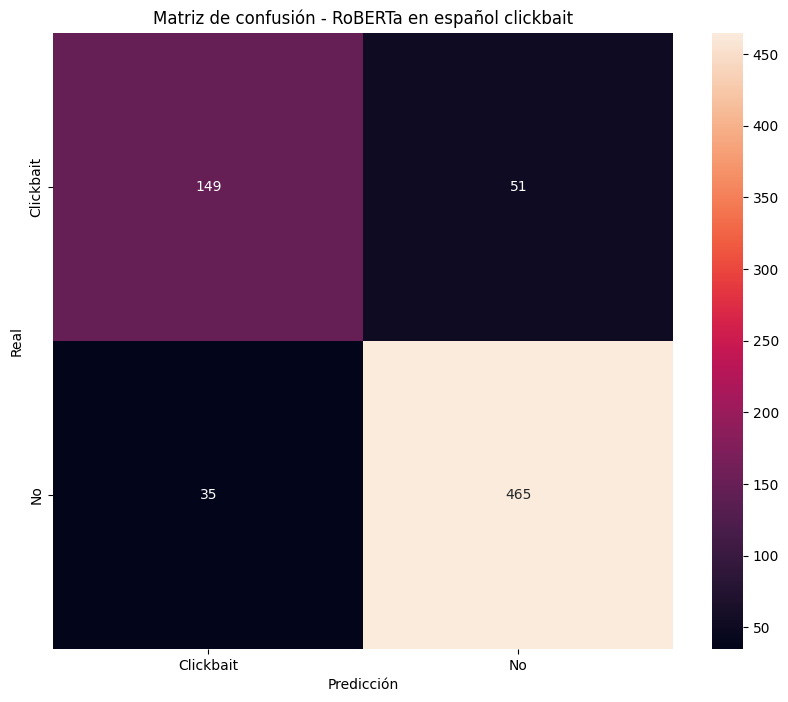


Reporte de clasificación RoBERTa en español:
              precision    recall  f1-score   support

   Clickbait       0.81      0.74      0.78       200
          No       0.90      0.93      0.92       500

    accuracy                           0.88       700
   macro avg       0.86      0.84      0.85       700
weighted avg       0.88      0.88      0.88       700



In [21]:
predictions = trainer.predict(eval_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - RoBERTa en español clickbait")
plt.show()

print("\nReporte de clasificación RoBERTa en español:")
class_RoBERTa = classification_report(y_true, y_pred, target_names=label_names)
print(class_RoBERTa)

## XLM-R base (RoBERTa multilingüe entrenado en un montón de idiomas)

Modelo y Tokenización

In [22]:
MODEL_NAME = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

encoded_dataset = dataset.map(tokenize_function, batched=True)

encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

train_dataset = encoded_dataset["train"]
eval_dataset  = encoded_dataset["test"]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ejemplo de tokenización

In [23]:
tokens = tokenizer.tokenize(ejemplo)
print("Tokens:\n", tokens)

encoding = tokenizer(
    ejemplo,
    truncation=True,
    padding="max_length",
    max_length=128,
)

print("\n", encoding.keys())
print("\n", encoding["input_ids"][:20])
print("\n", encoding["attention_mask"][:20])

decodificado = tokenizer.decode(encoding["input_ids"], skip_special_tokens=True)
print("\nMensaje decodificado:\n", decodificado)

Tokens:
 ['▁san', 'idad', '▁revend', 'e', '▁30.000', '▁dosis', '▁de', '▁la', '▁vacuna', '▁contra', '▁el', '▁corona', 'virus', '▁a', '▁', 'Andorra']

 KeysView({'input_ids': [0, 3725, 3812, 191527, 13, 95829, 101424, 8, 21, 235903, 2304, 88, 109728, 76912, 10, 6, 124180, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Trainer con el modelo actual

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

Entrenamiento

In [25]:
print("Entrenando modelo XLM-R base para clickbait")
trainer.train()
print("\nEvaluando en test")
metrics_XLM = trainer.evaluate()
print("\nMétricas de evaluación:", metrics_XLM)

Entrenando modelo XLM-R base para clickbait


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.371300,0.487009,0.858571,0.828029,0.859089,0.825696,0.830500
2,0.359500,0.588752,0.858571,0.814567,0.853281,0.844110,0.796000
3,0.184600,0.570571,0.867143,0.837493,0.867242,0.836992,0.838000
4,0.160200,0.660833,0.868571,0.834933,0.866868,0.844414,0.827000
5,0.115600,0.789361,0.867143,0.840297,0.868359,0.834519,0.847000
6,0.044500,0.976134,0.867143,0.832867,0.865305,0.842983,0.824500
7,0.043900,0.904479,0.875714,0.845635,0.874838,0.850754,0.841000
8,0.035300,1.057977,0.871429,0.839041,0.869985,0.847266,0.832000
9,0.002600,1.097657,0.874286,0.843615,0.873296,0.849329,0.838500
10,0.030700,1.202183,0.865714,0.840136,0.867541,0.831913,0.850500



Evaluando en test



Métricas de evaluación: {'eval_loss': 0.9044790863990784, 'eval_accuracy': 0.8757142857142857, 'eval_f1_macro': 0.8456348109976959, 'eval_f1_weighted': 0.874838184508948, 'eval_precision_macro': 0.8507544821485512, 'eval_recall_macro': 0.841, 'eval_runtime': 1.3476, 'eval_samples_per_second': 519.43, 'eval_steps_per_second': 65.3, 'epoch': 15.0}


Metricas

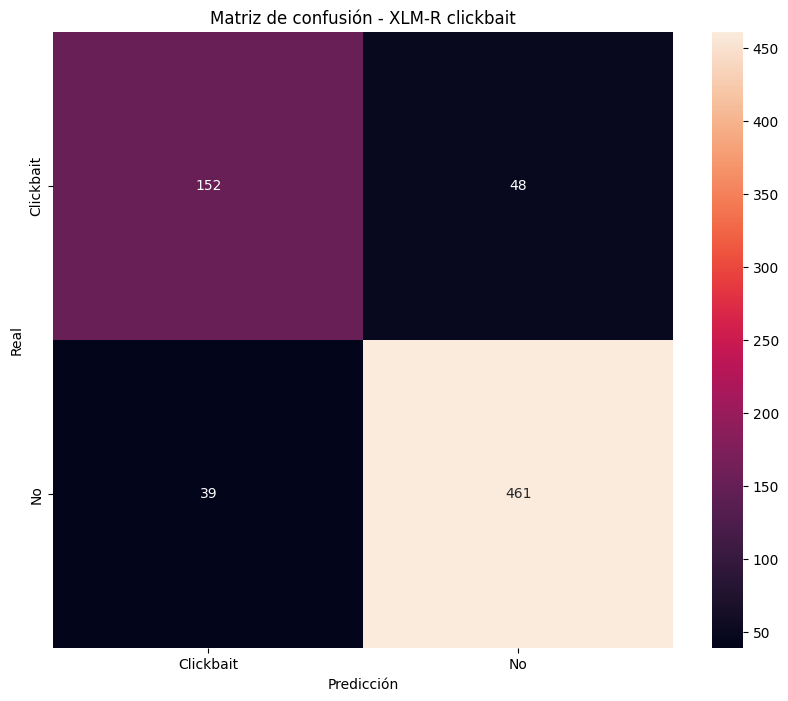


Reporte de clasificación XLM-R:
              precision    recall  f1-score   support

   Clickbait       0.80      0.76      0.78       200
          No       0.91      0.92      0.91       500

    accuracy                           0.88       700
   macro avg       0.85      0.84      0.85       700
weighted avg       0.87      0.88      0.87       700



In [26]:
predictions = trainer.predict(eval_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - XLM-R clickbait")
plt.show()

print("\nReporte de clasificación XLM-R:")
class_XLM = classification_report(y_true, y_pred, target_names=label_names)
print(class_XLM)

## DistilBERT m-cased (DistilBERT miltilenguaje)

Modelo y Tokenización

In [27]:
MODEL_NAME = "distilbert/distilbert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

encoded_dataset = dataset.map(tokenize_function, batched=True)

encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

train_dataset = encoded_dataset["train"]
eval_dataset  = encoded_dataset["test"]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ejemplo de tokenización

In [28]:
tokens = tokenizer.tokenize(ejemplo)
print("Tokens:\n", tokens)

encoding = tokenizer(
    ejemplo,
    truncation=True,
    padding="max_length",
    max_length=128,
)

print("\n", encoding.keys())
print("\n", encoding["input_ids"][:20])
print("\n", encoding["attention_mask"][:20])

decodificado = tokenizer.decode(encoding["input_ids"], skip_special_tokens=True)
print("\nMensaje decodificado:\n", decodificado)

Tokens:
 ['san', '##idad', 'rev', '##ende', '30', '.', '000', 'dos', '##is', 'de', 'la', 'va', '##cun', '##a', 'contra', 'el', 'corona', '##vir', '##us', 'a', 'Andorra']

 KeysView({'input_ids': [101, 14608, 13811, 86095, 13201, 10244, 119, 10259, 10398, 10291, 10104, 10109, 10321, 48917, 10113, 11473, 10125, 31206, 37715, 10251, 169, 42980, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Trainer con el modelo actual

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

Entrenamiento

In [30]:
print("Entrenando modelo DistilBERT m-cased para clickbait")
trainer.train()
print("\nEvaluando en test")
metrics_DistilBERT = trainer.evaluate()
print("\nMétricas de evaluación:", metrics_DistilBERT)

Entrenando modelo DistilBERT m-cased para clickbait


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.408200,0.437130,0.841429,0.799866,0.838953,0.810308,0.791500
2,0.228000,0.547150,0.842857,0.807500,0.842857,0.807500,0.807500
3,0.180900,0.600188,0.852857,0.816670,0.851577,0.822534,0.811500
4,0.150500,0.769407,0.845714,0.795832,0.839083,0.828838,0.776500
5,0.048000,0.936530,0.844286,0.810658,0.844856,0.808450,0.813000
6,0.057400,0.895718,0.854286,0.813292,0.850786,0.830889,0.800500
7,0.016800,1.009192,0.855714,0.815439,0.852389,0.832343,0.803000
8,0.000200,1.174358,0.844286,0.807202,0.843440,0.810676,0.804000
9,0.001800,1.129090,0.860000,0.816774,0.854915,0.845486,0.798500
10,0.007300,1.203058,0.845714,0.808073,0.844500,0.813209,0.803500



Evaluando en test



Métricas de evaluación: {'eval_loss': 1.129089593887329, 'eval_accuracy': 0.86, 'eval_f1_macro': 0.8167735042735043, 'eval_f1_weighted': 0.8549145299145299, 'eval_precision_macro': 0.8454861111111112, 'eval_recall_macro': 0.7985, 'eval_runtime': 0.761, 'eval_samples_per_second': 919.861, 'eval_steps_per_second': 115.64, 'epoch': 15.0}


Metricas

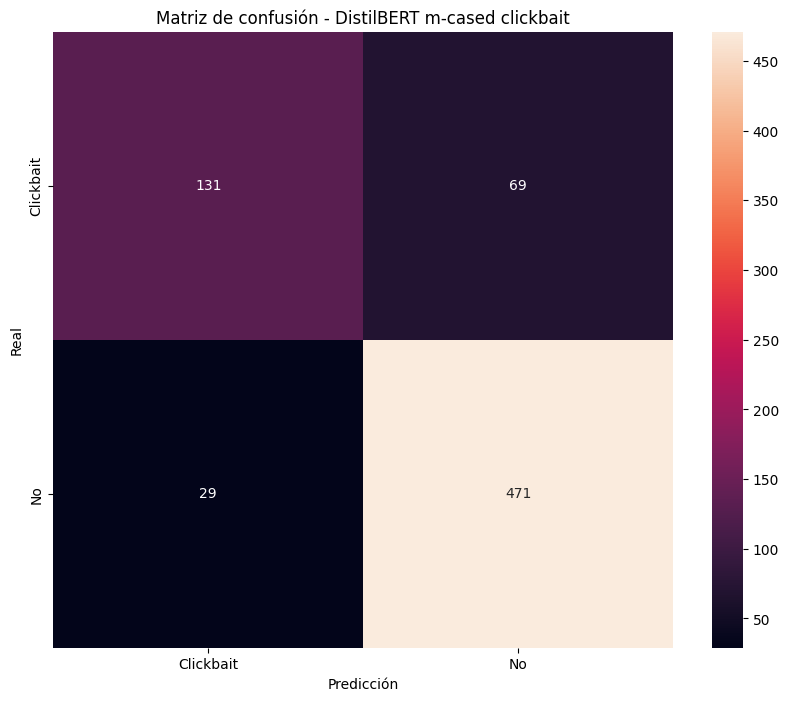


Reporte de clasificación DistilBERT m-cased:
              precision    recall  f1-score   support

   Clickbait       0.82      0.66      0.73       200
          No       0.87      0.94      0.91       500

    accuracy                           0.86       700
   macro avg       0.85      0.80      0.82       700
weighted avg       0.86      0.86      0.85       700



In [31]:
predictions = trainer.predict(eval_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - DistilBERT m-cased clickbait")
plt.show()

print("\nReporte de clasificación DistilBERT m-cased:")
class_DistilBERT = classification_report(y_true, y_pred, target_names=label_names)
print(class_DistilBERT)

# Comparación de modelos

In [32]:
def get_metric(m, name):
    # Busca 'eval_name' o 'name' dentro del dict de métricas.
    return m.get(f"eval_{name}", m.get(name, None))

resultados = [
    {
        "Modelo": "DistilBERT-multilingüe",
        "Accuracy":      get_metric(metrics_DistilBERT, "accuracy"),
        "F1_macro":      get_metric(metrics_DistilBERT, "f1_macro"),
        "F1_weighted":   get_metric(metrics_DistilBERT, "f1_weighted"),
        "Loss":          get_metric(metrics_DistilBERT, "loss"),
    },
    {
        "Modelo": "XLM-R",
        "Accuracy":      get_metric(metrics_XLM, "accuracy"),
        "F1_macro":      get_metric(metrics_XLM, "f1_macro"),
        "F1_weighted":   get_metric(metrics_XLM, "f1_weighted"),
        "Loss":          get_metric(metrics_XLM, "loss"),
    },
    {
        "Modelo": "RoBERTa-es",
        "Accuracy":      get_metric(metrics_RoBERTa, "accuracy"),
        "F1_macro":      get_metric(metrics_RoBERTa, "f1_macro"),
        "F1_weighted":   get_metric(metrics_RoBERTa, "f1_weighted"),
        "Loss":          get_metric(metrics_RoBERTa, "loss"),
    },
    {
        "Modelo": "DistilBETO",
        "Accuracy":      get_metric(metrics_destil, "accuracy"),
        "F1_macro":      get_metric(metrics_destil, "f1_macro"),
        "F1_weighted":   get_metric(metrics_destil, "f1_weighted"),
        "Loss":          get_metric(metrics_destil, "loss"),
    },
    {
        "Modelo": "BETO",
        "Accuracy":      get_metric(metrics_BETO, "accuracy"),
        "F1_macro":      get_metric(metrics_BETO, "f1_macro"),
        "F1_weighted":   get_metric(metrics_BETO, "f1_weighted"),
        "Loss":          get_metric(metrics_BETO, "loss"),
    },
]

df_resultados = pd.DataFrame(resultados)

# Ordenar por F1_macro descendente
df_resultados = df_resultados.sort_values("F1_macro", ascending=False)

print(df_resultados.to_string(index=False))

                Modelo  Accuracy  F1_macro  F1_weighted     Loss
                  BETO  0.895714  0.861216     0.890871 0.971870
            RoBERTa-es  0.877143  0.845698     0.875551 0.783551
                 XLM-R  0.875714  0.845635     0.874838 0.904479
            DistilBETO  0.861429  0.828956     0.860896 1.052867
DistilBERT-multilingüe  0.860000  0.816774     0.854915 1.129090


# Generación del CSV detection.csv

Carga del dataset de prueba

In [33]:
test_df = pd.read_csv("TA1C_dataset_detection_test.csv")
print(test_df.head())

              Tweet ID  Tweet Date Media Name Media Origin  \
0  1303657772261703680  09-09-2020    El País      Uruguay   
1  1292878011839197188  10-08-2020    El País      Uruguay   
2  1287169218975281154  25-07-2020    El País      Uruguay   
3  1300152220214792192  30-08-2020    infobae    Argentina   
4  1298341509033418752  25-08-2020    infobae    Argentina   

                                         Teaser Text  
0  El mapa del desafuero de Manini Ríos: uno a un...  
1  #Peñarol  | Diego Forlán: "Queríamos ganar, pe...  
2  Benzema se ríe de los elogios del presidente d...  
3  “The Vow”: las sectas y las promesas de felici...  
4  Estados Unidos sancionó a un alto narcotrafica...  


Hacer el Dataset de HF

In [34]:
test_hf = Dataset.from_pandas(test_df[["Teaser Text"]])

def tokenize_test(examples):
    return tokenizer(
        examples["Teaser Text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )

test_encoded = test_hf.map(tokenize_test, batched=True)
test_encoded.set_format(type="torch", columns=["input_ids", "attention_mask"])

Map: 100%|██████████| 700/700 [00:00<00:00, 10495.54 examples/s]


Predicciones con el mejor modelo.

In [35]:
predicciones = trainer.predict(test_encoded)
pred_ids = np.argmax(predicciones.predictions, axis=-1)

label_names = dataset["train"].features["labels"].names
print("Label names:", label_names)

pred_tags = [label_names[i] for i in pred_ids]

Label names: ['Clickbait', 'No']


Contruir y guardar el dataset final

In [36]:
submission = pd.DataFrame({
    "Tweet ID": test_df["Tweet ID"],
    "Tag Value": pred_tags,
})

print(submission.head())

submission.to_csv("detection.csv", index=False)
print("Archivo detection.csv guardado con", len(submission), "filas")

              Tweet ID  Tag Value
0  1303657772261703680  Clickbait
1  1292878011839197188  Clickbait
2  1287169218975281154         No
3  1300152220214792192  Clickbait
4  1298341509033418752         No
Archivo detection.csv guardado con 700 filas
